In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0           0       0       0       0       0       0       0       0       0   
 1           0       0       0       0       0       0       0       0       0   
 2           0       0       0       0       0       0       0       0       0   
 3           0       0       0       0       0       0       0       0       0   
 4           0       0       0       0       0       0       0       0       0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995       0       0       0       0       0       0       0       0       0   
 69996       0       0       0       0       0       0       0       0       0   
 69997       0       0       0       0       0       0       0       0       0   
 69998       0       0       0       0       0       0       0       0       0   
 69999       0       0       0       0       0       0       0       0       0   
 
      

In [2]:
X,y = mnist["data"], mnist["target"]
print(X.shape)
y.shape


(70000, 784)


(70000,)

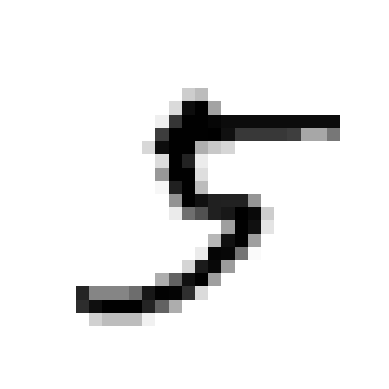

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X.iloc[36011]
some_digit_image = some_digit.to_numpy().reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [4]:
y[36011]

'5'

In [5]:
import numpy as np

X_np = X.to_numpy()  # shape: (70000, 784)
y_np = y.to_numpy()  # shape: (70000, )
# Пример разделения на train/test
X_train, X_test = X_np[:60000], X_np[60000:]
y_train, y_test = y_np[:60000], y_np[60000:]

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index] 

In [6]:
y_train_5 = (y_train == "5") #True для всех пятерок, false для всех остальных цифр
y_test_5 = (y_test == "5")

In [7]:
#обучаем классификатор(градиентный спуск)
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
#угадываем 5
sgd_clf.predict([X.iloc[36011]])

array([ True])

In [9]:
y[36011]

'5'

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9557 , 0.9648 , 0.94685])

In [11]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90915, 0.91265, 0.90715])

In [12]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
# строим матрицу неточностей для 5
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53327,  1252],
       [ 1401,  4020]], dtype=int64)

In [14]:
# смотрим на пресижн и рекол
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7625189681335357
0.7415605976757056


In [15]:
#f1 мера
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7518937622743851

In [16]:
# смотрим на порог принятия решений в классификации 5
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

[2819.35899635]


array([ True])

In [17]:
#увеличиваем порог. теперь 5 не проходит
threshold = 4000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [18]:
#смотрим сумму всех очков decision_function
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([-13299.56483946, -12520.85284116, -12868.57894086, ...,
         9187.06006698,   2497.3691721 ,  11382.2509627 ])

In [19]:
#вычисляем точностьи полноту для всех возможных порогов
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


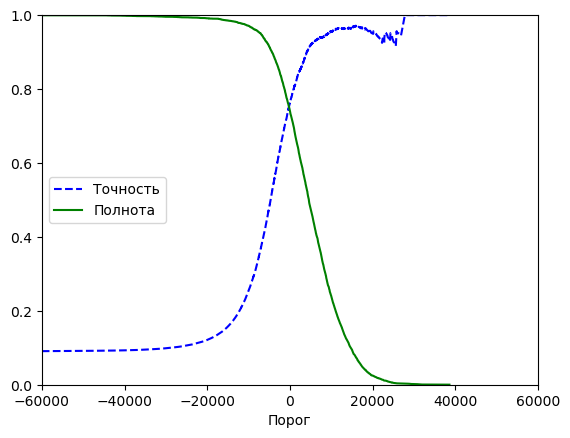

In [20]:
# смотрим точность и полноту на графике
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Точность")
    plt.plot(thresholds, recalls[:-1], "g-", label="Полнота")
    plt.xlabel("Порог")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    plt.xlim([-60000, 60000])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [21]:
y_train_pred_90 = (y_scores > 100)

In [22]:
precision_score(y_train_5, y_train_pred_90)

0.7664107485604607

In [23]:
recall_score(y_train_5, y_train_pred_90)

0.7365799667957942

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

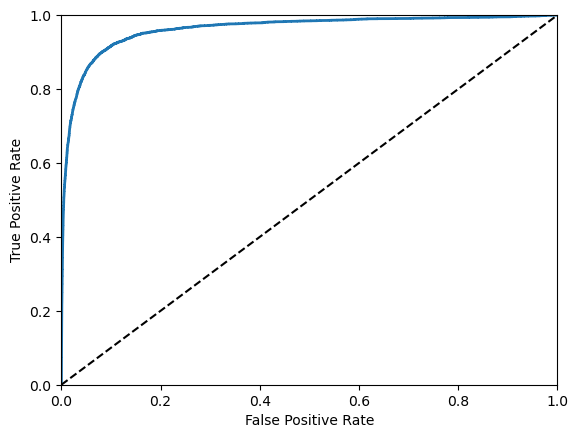

In [25]:
#смотрим метрику кривая roc
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

plot_roc_curve(fpr, tpr)
plt.show()

In [26]:
#вычисляем площад под кривой roc
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9623050224775848

In [27]:
# сравниваем random forest с sgdclassifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [28]:
y_probas_forest

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [0.88, 0.12],
       [0.56, 0.44],
       [0.05, 0.95]])

In [29]:
y_scores_forest = y_probas_forest[:, 1] # показатель = вероятность положительного класса
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

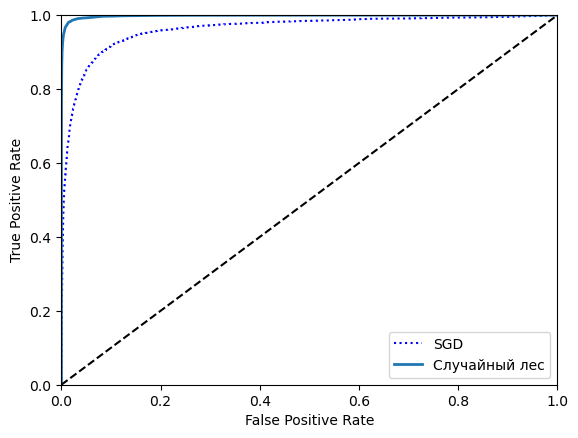

In [30]:
# сравниваем две кривых на графике
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Случайный лес")
plt.legend(loc="lower right")
plt.show()

In [31]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983759319322804

In [32]:
threshold = 0.5
y_pred_forest = (y_scores_forest > threshold)

In [33]:
from sklearn.metrics import precision_score
precision_score(y_train_5, y_pred_forest)

0.9903584154265354

In [34]:
recall_score(y_train_5, y_pred_forest)

0.8716104039845047

In [35]:
# обучаем SGD на всем наборе меток, а не только y_train_5. стратегия OvA(один против всех)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [36]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-14331.25472787,  -8302.22284496,  -7066.79688752,
         -8377.37034582, -16996.88911487,   2957.78582395,
        -27813.09398556,  -2998.36208311,  -5863.70078898,
         -5131.67340926]])

In [37]:
np.argmax(some_digit_scores)

5

In [38]:
sgd_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [39]:
sgd_clf.classes_[5]

'5'

In [40]:
# применяем стратегию OvO 
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
len(ovo_clf.estimators_)

['5']


45

In [41]:
# обучаем деревья решений
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array(['5'], dtype=object)

In [42]:
# смотрим список вероятностей
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.  , 0.04, 0.01, 0.92, 0.  , 0.  , 0.01, 0.02]])

In [43]:
# перекрестная проверка
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.85615, 0.87645, 0.878  ])

In [45]:
# добавляем масштабирование входных данных
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

D:\programs\Anaconda\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.90045, 0.89755, 0.90375])

In [46]:
# АНАЛИЗ ОШИБОК
# строим матрицу неточностей
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_m = confusion_matrix(y_train, y_train_pred)
conf_m

D:\programs\Anaconda\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[5593,    0,   15,    7,    9,   39,   34,    5,  220,    1],
       [   0, 6418,   41,   27,    3,   45,    4,    7,  186,   11],
       [  26,   30, 5257,   80,   70,   25,   63,   40,  360,    7],
       [  30,   21,  117, 5225,    2,  212,   25,   46,  388,   65],
       [  11,   14,   48,   11, 5235,    8,   29,   22,  308,  156],
       [  29,   19,   29,  157,   48, 4475,   74,   18,  507,   65],
       [  28,   16,   53,    2,   41,   95, 5540,    8,  134,    1],
       [  19,   14,   54,   19,   46,   11,    4, 5711,  177,  210],
       [  14,   59,   43,   90,    1,  114,   32,    9, 5444,   45],
       [  22,   19,   29,   61,  127,   41,    1,  176,  336, 5137]],
      dtype=int64)

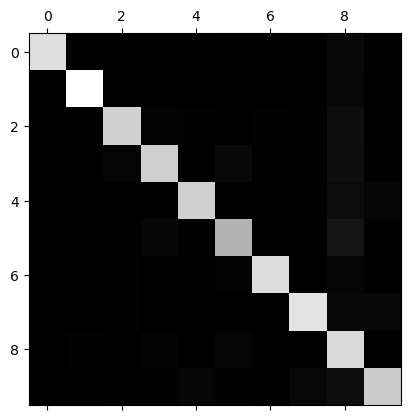

In [48]:
#строим график матрицы неточностей
plt.matshow(conf_m, cmap=plt.cm.gray)
plt.show()

In [52]:
#высчитываем частоту ошибок
row_sums = conf_m.sum(axis=1, keepdims=True)
norm_conf_mx = conf_m / row_sums

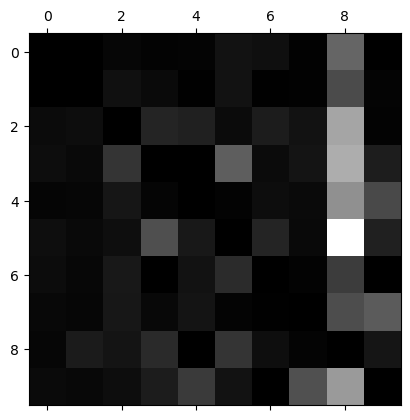

In [54]:
#результирующий график(концентрируемся на ошибках)
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [56]:
# визуализация троек и пятерок
# нет функции plot_digits
# cl_a, cl_b = 3, 5
# X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
# X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
# X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
# X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
# plt.figure(figsize=(8,8))
# plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
# plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
# plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
# plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
# plt.show()

In [62]:
# создаем простой многоклассовый классификатор
# np.c_ объединяет одномерные массивы в двумерный
from sklearn.neighbors import KNeighborsClassifier
y_train_int = y_train.astype(int)
y_train_large = (y_train_int >= 7)
y_train_odd = (y_train_int % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [65]:
# код сверху создает массив с двумя метками. 
#первая указывает, является и цифра большой, а вторая - нечетная ли цифра
y_multilabel

array([[False, False],
       [False,  True],
       [False, False],
       ...,
       [False,  True],
       [False,  True],
       [False,  True]])

In [67]:
#смотрим прогноз модели на нашем числе (5) 
# цифра 5 небольшая (false), и четная (true)
knn_clf.predict([some_digit])

array([[False,  True]])

In [68]:
# вычисляем среднюю f1 меру
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9769656933547983